In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch_directml
from stable_baselines3 import DQN
import matplotlib.pyplot as plt
import import_ipynb

In [2]:
class PairsTradingEnv(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self, asset1, asset2, start_date, end_date, window):
        super().__init__()
        self.asset1 = asset1
        self.asset2 = asset2
        self.window = window

        # Download data and compute technical indicators
        df = yf.download([asset1, asset2], start=start_date, end=end_date, progress=False)["Close"]
        df.columns.name = None
        df["ratio"] = df[asset1] / df[asset2]
        df["ratio_ma"] = df["ratio"].rolling(window=window).mean()
        df["ratio_std"] = df["ratio"].rolling(window=window).std()
        df["z_score"] = (df["ratio"] - df["ratio_ma"]) / df["ratio_std"]
        df[f"{asset1}_return"] = df[asset1].pct_change()
        df[f"{asset2}_return"] = df[asset2].pct_change()
        df.dropna(inplace=True)
        self.data = df.reset_index(drop=True)

        # Observation: [price1, price2, ratio, ratio_ma, ratio_std, z_score]
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32
        )
        # Action space:
        # 0: Flat, 1: Long asset1/Short asset2, 2: Short asset1/Long asset2
        self.action_space = gym.spaces.Discrete(3)

        self.reset()

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        return np.array([
            row[self.asset1],
            row[self.asset2],
            row["ratio"],
            row["ratio_ma"],
            row["ratio_std"],
            row["z_score"]
        ], dtype=np.float32)

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())
            
        # Map actions to positions
        action_mapping = {
            0: np.array([0, 0]),   # Flat
            1: np.array([1, -1]),  # Long asset1, short asset2
            2: np.array([-1, 1])   # Short asset1, long asset2
        }
        new_position = action_mapping[action]

        # Calculate reward using the position from the previous step.
        # For the first step, reward is zero.
        if self.current_step == self.window:
            reward = 0.0
        else:
            r1 = self.data.iloc[self.current_step][f"{self.asset1}_return"]
            r2 = self.data.iloc[self.current_step][f"{self.asset2}_return"]
            reward = self.position[0] * r1 + self.position[1] * r2

        # Update to the new position (applied on the next day)
        self.position = new_position
        self.current_step += 1

        done = self.current_step >= len(self.data) - 1
        obs = self._get_obs() if not done else np.zeros(self.observation_space.shape, dtype=np.float32)
        info = {}
        # Gymnasium's step now returns (obs, reward, done, truncated, info)
        return obs, reward, done, False, info

    def reset(self, **kwargs):
        self.current_step = self.window  # start where indicators are defined
        self.position = np.array([0, 0])
        return self._get_obs(), {}

    def render(self, mode="human"):
        obs = self._get_obs()
        print(f"Step: {self.current_step}, Obs: {obs}, Position: {self.position}")

In [3]:
dml = torch_directml.device()   # gpu not working

env = PairsTradingEnv(asset1="BTC-EUR", asset2="BTC-GBP", start_date="2020-2-21", end_date="2025-02-21", window=5)

model = DQN("MlpPolicy", env, device="cpu", verbose=1)

model.learn(total_timesteps=100000)

YF.download() has changed argument auto_adjust default to True
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82e+03 |
|    ep_rew_mean      | 0.142    |
|    exploration_rate | 0.31     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1595     |
|    time_elapsed     | 4        |
|    total_timesteps  | 7268     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 43.7     |
|    n_updates        | 1791     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82e+03 |
|    ep_rew_mean      | 0.0521   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1472     |
|    time_elapsed     | 9        |
|  

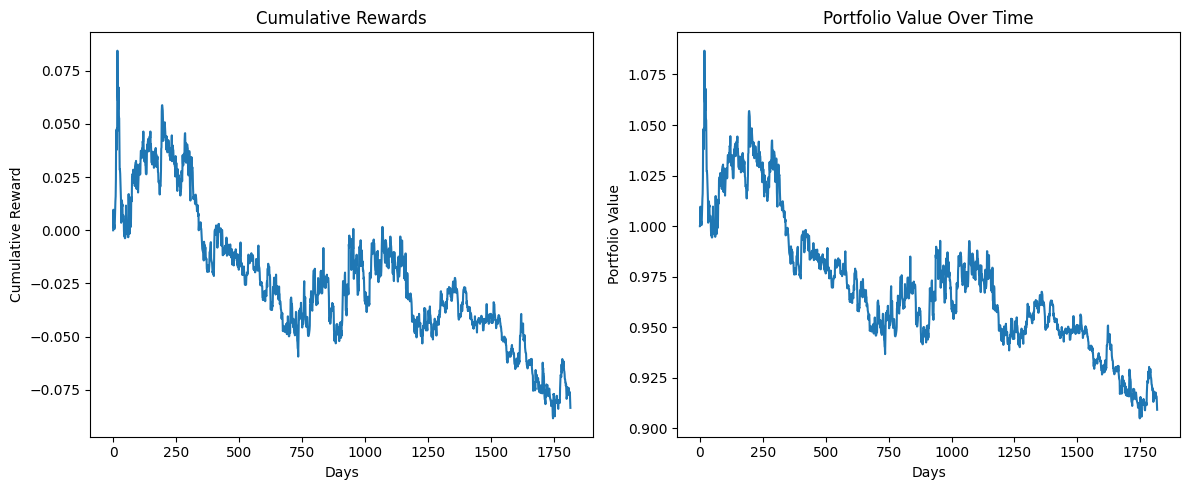

In [4]:
obs, _ = env.reset()
done = False
episode_rewards = []
portfolio_values = [1]  # starting portfolio value

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    episode_rewards.append(reward)
    # update portfolio value (assuming rewards are returns)
    portfolio_values.append(portfolio_values[-1] * (1 + reward))
    
# Plot cumulative rewards
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.cumsum(episode_rewards))
plt.title("Cumulative Rewards")
plt.xlabel("Days")
plt.ylabel("Cumulative Reward")

# Plot portfolio value
plt.subplot(1,2,2)
plt.plot(portfolio_values)
plt.title("Portfolio Value Over Time")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.tight_layout()
plt.show()
